<a href="https://colab.research.google.com/github/der-himmel/obr-iz/blob/main/obr_iz_pz3_noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Установка нужных зависимостей

In [ ]:
!pip install opencv-python

!pip install numpy

!pip install matplotlib

# Импортируем библиотеки

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage import io

In [2]:
image_height = 150
image_width = 150
dpi = 100

In [109]:
scale_factor = 9.0
scale_factor_low = 0.75

In [82]:
urls = [
    # f"https://evivid.ru/vk/img.php?url=https%3A%2F%2Fsun9-40.userapi.com%2Fimpg%2FCNGYtv5mZs4rONGMJx0crZ6-ajN_8sbPFP93wA%2FONDINN4x9aQ.jpg%3Fsize%3D429x604%26quality%3D96%26sign%3D701e7d60fa1fea0d6207e0a422c9d7eb%26c_uniq_tag%3DZESB4zRepXZuywLbaczntiMWkgX5Uiovn25WomRgztY%26type%3Dalbum",
    # f"https://cdn.frankerfacez.com/emoticon/391932/4",
    # f"http://www.lenna.org/len_std.jpg"
    ]

In [96]:
images = list()

for url in urls:
    image = io.imread(url)
    images.append(image)

In [105]:
def generate_noise_img(width: int, height: int) -> np.ndarray:
    noise_image = np.random.randint(0, 256, (height, width, 3), dtype=np.uint8)
    return noise_image

noise_img = generate_noise_img(width=50, height=50)

In [104]:
def show_image(image: np.ndarray, dpi: int) -> None:
    image_height, image_width, _ = image.shape
    plt.figure(
        figsize=(
            image_width / float(dpi),
            image_height / float(dpi)
        )
    )
    plt.imshow(image)
    plt.axis('off')
    plt.show()

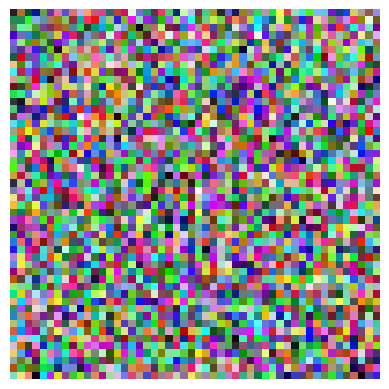

In [110]:
# img = images[0]
# show_image(img, dpi)

img = noise_img
plt.imshow(img)
plt.axis('off')
plt.show()

## Ближайшие соседи (Neares Neighbour)

In [91]:
def nearest_neighbour_interpolation(image: np.ndarray, scale_factor: float) -> np.ndarray:
    original_height, original_width, channels = image.shape
    new_height = int(original_height * scale_factor)
    new_width = int(original_width * scale_factor)
    resized = np.zeros((new_height, new_width, channels), dtype=image.dtype)

    height_ratio = original_height / new_height
    width_ratio = original_width / new_width

    for i in range(new_height):
        for j in range(new_width):
            original_x = int(j * width_ratio)
            original_y = int(i * height_ratio)
            resized[i, j] = image[original_y, original_x]

    return resized

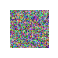

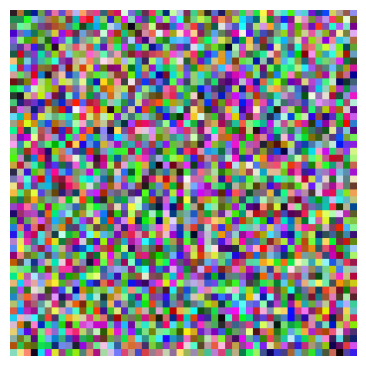

In [111]:
nearest_resized = nearest_neighbour_interpolation(img, scale_factor)
nearest_resized_low = nearest_neighbour_interpolation(img, scale_factor_low)

show_image(img, dpi)
show_image(nearest_resized, dpi)

## Билинейная интерполяция (Bilinear interpolation)

In [59]:
def bilinear_interpolation(image: np.ndarray, scale_factor: float) -> np.ndarray:
    original_height, original_width, channels = image.shape
    new_height = int(original_height * scale_factor)
    new_width = int(original_width * scale_factor)
    pad_h, pad_w = 1, 1
    padded = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w), (0, 0)), mode='edge')

    result = np.zeros((new_height, new_width, channels), dtype=np.uint8)

    for i in range(new_height):
        for j in range(new_width):
            # координаты
            x = i / scale_factor
            y = j / scale_factor
            l = int(x)
            k = int(y)

            # веса
            a = x - l
            b = y - k

            result[i][j] = (
                padded[l][k] * (1 - a) * (1 - b) +
                padded[l + 1][k] * a * (1 - b) +
                padded[l][k + 1] * (1 - a) * b +
                padded[l + 1][k + 1] * a * b
            )

    return result

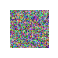

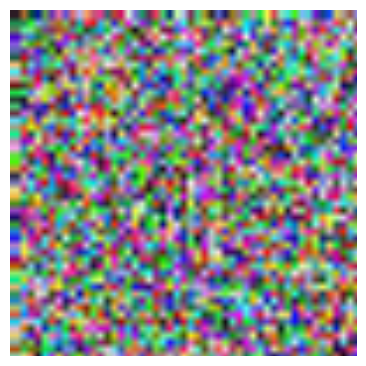

In [112]:
bilinear_resized = bilinear_interpolation(img, scale_factor)
bilinear_resized_low = bilinear_interpolation(img, scale_factor_low)

show_image(img, dpi)
show_image(bilinear_resized, dpi)

## Бикубическая интерполяция (Bicubic Interpolation)

In [61]:
# веса
def weight(x):
    a = -0.5
    x = abs(x)
    if x <= 1:
        return (a + 2) * x**3 - (a + 3) * x**2 + 1
    elif x < 2:
        return a * x**3 - 5 * a * x**2 + 8 * a * x - 4 * a
    return 0

def bicubic_interpolation(image: np.ndarray, scale_factor: float) -> np.ndarray:
    original_height, original_width, channels = image.shape
    new_height = int(original_height * scale_factor)
    new_width = int(original_width * scale_factor)

    result = np.zeros((new_height, new_width, channels), dtype=np.float64)  # Используем float64 для временного хранения

    for i in range(new_height):
        for j in range(new_width):
            x = i / scale_factor
            y = j / scale_factor
            l = int(x)
            k = int(y)

            for c in range(channels):
                value = 0
                for m in range(-1, 3):
                    for n in range(-1, 3):
                        if 0 <= l + m < original_height and 0 <= k + n < original_width:
                            weight_value = weight(x - (l + m)) * weight(y - (k + n))
                            value += image[l + m][k + n][c] * weight_value
                result[i][j][c] = value

    result = np.clip(result, 0, 255)
    return result.astype(np.uint8)

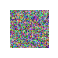

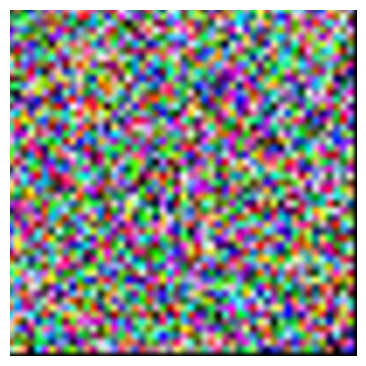

In [113]:
bicubic_resized = bicubic_interpolation(img, scale_factor)
bicubic_resized_low = bicubic_interpolation(img, scale_factor_low)

show_image(img, dpi)
show_image(bicubic_resized, dpi)

**СРАВНЕНИЕ**

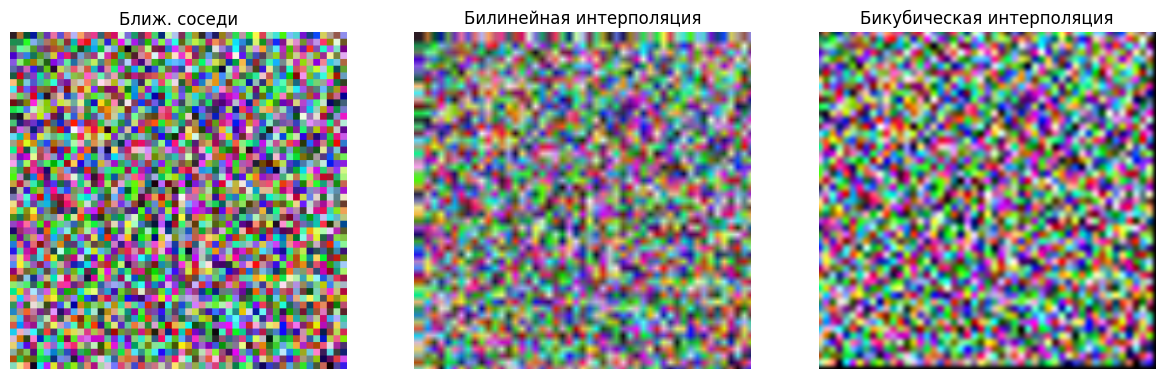

In [114]:
plt.figure(figsize=(20, 10))
plt.subplot(141), plt.imshow(nearest_resized), plt.axis('off'), plt.title('Ближ. соседи')
plt.subplot(142), plt.imshow(bilinear_resized), plt.axis('off'), plt.title('Билинейная интерполяция')
plt.subplot(143), plt.imshow(bicubic_resized), plt.axis('off'), plt.title('Бикубическая интерполяция')
plt.show()

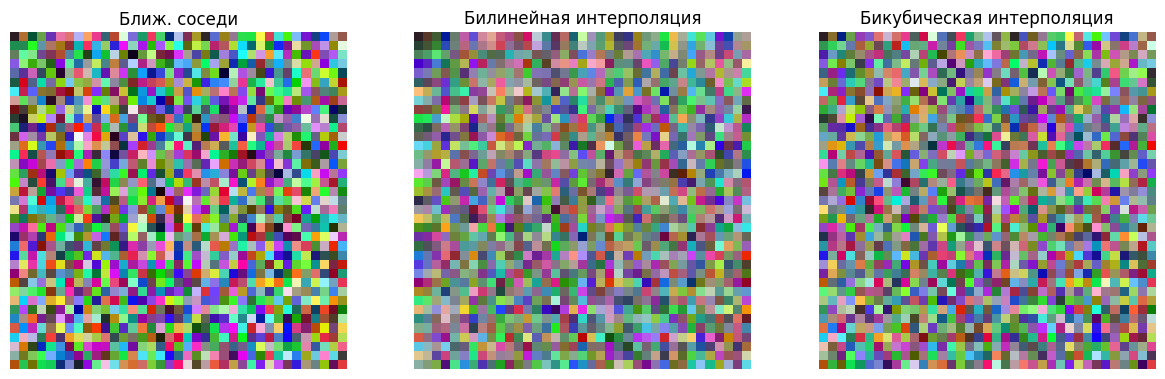

In [115]:
plt.figure(figsize=(20, 10))
plt.subplot(141), plt.imshow(nearest_resized_low), plt.axis('off'), plt.title('Ближ. соседи')
plt.subplot(142), plt.imshow(bilinear_resized_low), plt.axis('off'), plt.title('Билинейная интерполяция')
plt.subplot(143), plt.imshow(bicubic_resized_low), plt.axis('off'), plt.title('Бикубическая интерполяция')
plt.show()